In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import logging

logger = logging.getLogger(__name__)

os.chdir("../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.etl import *
from src.rfm import *
from src.utils import *

In [ ]:
url = "https://www.gutenberg.org/cache/epub/1533/pg1533-images.html"

make_dataset(url)

In [ ]:
X, vocab = tokenizer("./data/Author: William Shakespeare.txt")

In [ ]:
X.shape

In [ ]:
data = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

In [ ]:
data.shape

In [ ]:
vocab

## Baseline: Bigrams/Trigrams

In [4]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [5]:
CONTEXT_SIZE = 32
TEST_SPLIT = 0.2

In [6]:
def clean_sentence(sent):
    # remove newline and separate into characters
    sent = list(sent[:-1])
    # add start token and truncate to context size
    sent = (["<START>"] + sent)[:CONTEXT_SIZE]
    # pad to context size
    if len(sent) == CONTEXT_SIZE:
        return sent
    elif len(sent) < CONTEXT_SIZE:
        # add end token
        sent = sent + ["<END>"]
        return sent + ["<PAD>"] * (CONTEXT_SIZE - len(sent))
    else:
        raise ValueError("Sentence too long after truncating. Something went wrong.")


In [7]:
# get the text

fpath = "./data/Author: William Shakespeare.txt"
raw = open(fpath, "r").readlines()
sentences = list(map(clean_sentence, raw))
train_sentences = sentences[:int(len(sentences) * (1 - TEST_SPLIT))]
test_sentences = sentences[int(len(sentences) * (1 - TEST_SPLIT)):]
len(train_sentences)

682

In [8]:
np.array(train_sentences)[:, :16].shape

(682, 16)

In [9]:
# shop the dataset in half. The first half will be used to condition the second half
CONTEXT_SPLIT_SIZE = 16
X_train = np.array(train_sentences)[:, :16]
y_train = np.array(train_sentences)[:, 16:]
X_test = np.array(test_sentences)[:, :16]
y_test = np.array(test_sentences)[:, 16:]

In [10]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))

ngrams

[[('<START>', 'T'),
  ('T', 'i'),
  ('i', 't'),
  ('t', 'l'),
  ('l', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'M'),
  ('M', 'a'),
  ('a', 'c'),
  ('c', 'b'),
  ('b', 'e'),
  ('e', 't'),
  ('t', 'h'),
  ('h', '<END>')],
 [('<START>', 'A'),
  ('A', 'u'),
  ('u', 't'),
  ('t', 'h'),
  ('h', 'o'),
  ('o', 'r'),
  ('r', ':'),
  (':', ' '),
  (' ', 'W'),
  ('W', 'i'),
  ('i', 'l'),
  ('l', 'l'),
  ('l', 'i'),
  ('i', 'a'),
  ('a', 'm')],
 [('<START>', 'R'),
  ('R', 'e'),
  ('e', 'l'),
  ('l', 'e'),
  ('e', 'a'),
  ('a', 's'),
  ('s', 'e'),
  ('e', ' '),
  (' ', 'D'),
  ('D', 'a'),
  ('a', 't'),
  ('t', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'N')],
 [('<START>', 'L'),
  ('L', 'a'),
  ('a', 'n'),
  ('n', 'g'),
  ('g', 'u'),
  ('u', 'a'),
  ('a', 'g'),
  ('g', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'E'),
  ('E', 'n'),
  ('n', 'g'),
  ('g', 'l'),
  ('l', 'i')],
 [('<START>', 'A'),
  ('A', 'C'),
  ('C', 'T'),
  ('T', ' '),
  (' ', 'I'),
  ('I', 'S'),
  ('S', 'c'),
  ('c', 'e'),
  ('e', 'n

In [11]:
# pad the text
vocab = list(flatten(sent for sent in X_train))

In [12]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [13]:
X_train[1]

array(['<START>', 'A', 'u', 't', 'h', 'o', 'r', ':', ' ', 'W', 'i', 'l',
       'l', 'i', 'a', 'm'], dtype='<U7')

In [14]:
def generate_text(lm, X_test, length=16):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [15]:
y_test.shape

(171, 16)

In [16]:
y_test_pred = np.array(generate_text(lm, X_test))

In [17]:
"".join(y_test[0]), "".join(y_test_pred[0])

(' the whetstone o', ' y, MANOX.MACBEN')

In [18]:
lm.vocab.unk_label

'<UNK>'

In [19]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [20]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, ',': 2, '-': 3, '.': 4, ':': 5, ';': 6, '<END>': 7, '<PAD>': 8, '<START>': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, '[': 35, ']': 36, 'a': 37, 'b': 38, 'c': 39, 'd': 40, 'e': 41, 'f': 42, 'g': 43, 'h': 44, 'i': 45, 'j': 46, 'k': 47, 'l': 48, 'm': 49, 'n': 50, 'o': 51, 'p': 52, 'q': 53, 'r': 54, 's': 55, 't': 56, 'u': 57, 'v': 58, 'w': 59, 'x': 60, 'y': 61, '—': 62, '’': 63, '“': 64, '<UNK>': 65})

In [36]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    y_perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
        y_perplexity.append(utils.perplexity(encode(y_test[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity), "true_perplexity": np.mean(y_perplexity) }

In [37]:
evaluate(y_test, y_test_pred)

{'bleu2': 0.19700228998185984,
 'perplexity': 12.740844676741247,
 'true_perplexity': 12.526818139778857}

## Laplacian Kernel

In [38]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [39]:
# one hot encode the data
X_train_enc = np.eye(len(train_vocab))[X_train_enc]
X_train_enc = X_train_enc.reshape(X_train_enc.shape[0], X_train_enc.shape[1]*X_train_enc.shape[2])
y_train_enc = np.eye(len(train_vocab))[y_train_enc]
y_train_enc = y_train_enc.reshape(y_train_enc.shape[0], y_train_enc.shape[1]*y_train_enc.shape[2])
X_test_enc = np.eye(len(train_vocab))[X_test_enc]
X_test_enc = X_test_enc.reshape(X_test_enc.shape[0], X_test_enc.shape[1]*X_test_enc.shape[2])
y_test_enc = np.eye(len(train_vocab))[y_test_enc]
y_test_enc = y_test_enc.reshape(y_test_enc.shape[0], y_test_enc.shape[1]*y_test_enc.shape[2])

In [40]:
from functools import partial

In [41]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [73]:
# train a laplace kernel
lam = 1
kernel = partial(utils.K_laplace_mat, gamma=0.025)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [74]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 2.68798410e-01,  0.00000000e+00,  3.57026525e-02, ...,
         3.18385549e-02,  0.00000000e+00,  0.00000000e+00],
       [ 8.03665828e-02,  0.00000000e+00, -2.04314102e-02, ...,
        -7.94758610e-03,  0.00000000e+00,  0.00000000e+00],
       [ 2.38647201e-01,  0.00000000e+00,  5.66607509e-03, ...,
        -1.67007651e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.27604748e-02,  0.00000000e+00,  7.56617279e-03, ...,
        -1.09487379e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.81853396e-01,  0.00000000e+00,  2.82378089e-02, ...,
         2.85882678e-02,  0.00000000e+00,  0.00000000e+00],
       [ 6.63803125e-02,  0.00000000e+00, -1.34030998e-02, ...,
         9.72784103e-05,  0.00000000e+00,  0.00000000e+00]])

In [75]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.30994152046783624

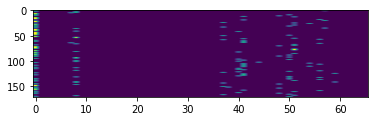

In [76]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

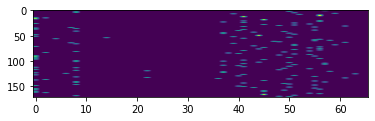

In [77]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [78]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

0.8123167155425219

In [79]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([train_vocab.decode(y) for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [80]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=16)

In [81]:
evaluate(y_test, generated_test)

{'bleu2': 0.21372329023610848,
 'perplexity': 6.919622905476647,
 'true_perplexity': 12.526818139778857}

## RFM

In [51]:
alpha, M = train_rfm(X_train_enc, next_char_train[:, 0])

mp: (682, 682)


/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:102: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
mp: (682, 682)
